# Introduction

This notebook describes the fine-tuning process of CNN. The base network is the [MovibleNetV2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

# Data upload

The dataset needs to be on the Colab virtual machine. Use a dataset located in Google Drive will result in a slow training process because the virtual machine needs to request and transfer the data from Google Drive during the training process.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The dataset is on Google Drive as a zip file and then copied into the virtual machine.

In [ ]:
!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/food.zip' .
!unzip -q food.zip
!rm food.zip

# Initialization

The dataset directory has the following structure:

```
images/
...class_a/
......image_1.jpg
......image_2.jpg
...class_b/
......image_3.jpg
......image_4.jpg
```

To train and test the model, we need three subsets: train, test and validation. To split the dataset, we use the [split-folder](https://pypi.org/project/split-folders/) package.

In [ ]:
!pip install split-folders tqdm

The training of a CNN on CPU could be unfeasible, so we check if the GPU hardware acceleration is active for the notebook.

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders

# constants
DATA_DIR = '/content/food-101/images'
SETS_DIR = '/content/sets'
BATCH_SIZE = 256

# check hardware acceleration
device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

GPU:  /device:GPU:0


It may happen that, during the unzip process, some image gets corrupted. A corrupted image will give an error during the training process, so we need to remove it. We used a piece of code from the Keras documentation slightly modified. It deletes the mac configuration file and the corrupted images.

In [ ]:
# remove corrupted images
num_skipped = 0
for folder_name in os.listdir(DATA_DIR):
    if folder_name == '.DS_Store':
      ds_store = os.path.join(DATA_DIR, folder_name)
      os.remove(ds_store)
      print("Removed: ", ds_store)
    else:
      folder_path = os.path.join(DATA_DIR, folder_name)
      for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
          fobj = open(fpath, "rb")
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
          fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            print("Removed: ", fpath)

print("Removed %d images" % num_skipped)

Removed:  /content/food-101/images/.DS_Store
Removed 0 images


We split the dataset into train, validation and test set. We use seventy per cent of images for the training set, fifteen per cent for the validation set and fifteen per cent for the test set.

In [ ]:
# split data
splitfolders.ratio(DATA_DIR, output=SETS_DIR, seed=123, ratio=(.7, .15, .15), group_prefix=None)

Copying files: 101000 files [02:10, 773.35 files/s]


We use the 'image_dataset_from_directory' function to create a Dataset object directly from the image directory. We take the class labels from the directory structure and transform them into integers to use them in the sparse categorical cross-entropy loss. We use buffered prefetching to yield data from disk without having I/O becoming blocking.

In [ ]:
train = SETS_DIR + '/train/'
val = SETS_DIR + '/val/'
test = SETS_DIR + '/test/'

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True, 
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    labels='inferred',
    label_mode='int',
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=BATCH_SIZE)

# use buffered prefetching so we can yield data 
# from disk without having I/O becoming blocking
train_set = train_set.prefetch(buffer_size=BATCH_SIZE)
val_set = val_set.prefetch(buffer_size=BATCH_SIZE)
test_set = test_set.prefetch(buffer_size=BATCH_SIZE)

Found 70700 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.


The MobileNetV2 needs input images with pixel normalized in [-1;1] (they vary in [0;255]) and size 224x224. To normalize the images, we use the function taken from exercise 6 of the laboratory.

In [ ]:
def preprocess(images, labels):
  images = tf.keras.applications.mobilenet_v2.preprocess_input(images)
  return images, labels
  
train_set = train_set.map(preprocess, deterministic=True)
val_set = val_set.map(preprocess, deterministic=True)
test_set = test_set.map(preprocess, deterministic=True)


# Training

The CNN has as base network the MobileNetV2 and an MLP with one hidden layer for classification. To use the pre-trained MobileNetV2, we load it removing the fully-connected layer on top.
Since the classification task is a multi-class classification problem with 101 classes, the output layer has 101 neurons with softmax activation function. To avoid overfitting, we use data augmentation. We perform data augmentation directly into the network using the first two layers that are active only during training. Furthermore, we apply global average pooling to the MobileNetV2.

In [ ]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3),
)

mobilenetv2.trainable = False

model = tf.keras.models.Sequential([
  # data augmentation
  tf.keras.Input(shape=(224,224,3)),
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2, seed=123, fill_mode='nearest'),

  # basenet
  mobilenetv2,
  tf.keras.layers.GlobalAveragePooling2D(),

  # classifier
  tf.keras.layers.Dense(256, activation='relu', name='dense_hidden'),
  tf.keras.layers.Dense(101, activation='softmax', name='output')

], name='food_classifier')

model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "food_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               327936    
_________________________________________________________________
output (Dense)               (None, 101)               25957     
Total params: 2,611,877
Trainable params: 353,893
Non-

We perform the training in two steps: first, we freeze the base network and train the classifier, then we un-freeze the last two blocks of the base network to fine-tune them. The MLP has random weights. Hence, the two-step training avoids destroying the pre-trained layers backpropagating large errors.

To train the model, we use the sparse categorical cross-entropy loss and the RMSprop optimizer. We perform early stopping to stop the training when the validation loss stops to improve, saving the model with the best validation accuracy.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.7),
              metrics=['accuracy'])

callbacks = [
    # early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2,
        restore_best_weights=True),

    # model checkpoints (save the best model)
    tf.keras.callbacks.ModelCheckpoint(
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        filepath='/content/gdrive/MyDrive/model/food_classifier.h5'),
]

history = model.fit(
      train_set,
      epochs=100,
      verbose=1,
      callbacks=callbacks,
      validation_data=val_set,
      batch_size=BATCH_SIZE)

Epoch 1/100
277/277 [==============================] - 291s 986ms/step - loss: 3.5405 - accuracy: 0.2194 - val_loss: 2.1116 - val_accuracy: 0.4724
Epoch 2/100
277/277 [==============================] - 278s 981ms/step - loss: 2.0714 - accuracy: 0.4855 - val_loss: 1.8599 - val_accuracy: 0.5300
Epoch 3/100
277/277 [==============================] - 261s 920ms/step - loss: 1.8676 - accuracy: 0.5256 - val_loss: 1.7764 - val_accuracy: 0.5466
Epoch 4/100
277/277 [==============================] - 245s 869ms/step - loss: 1.7605 - accuracy: 0.5524 - val_loss: 1.7345 - val_accuracy: 0.5548
Epoch 5/100
277/277 [==============================] - 214s 756ms/step - loss: 1.6954 - accuracy: 0.5654 - val_loss: 1.6929 - val_accuracy: 0.5654
Epoch 6/100
277/277 [==============================] - 212s 752ms/step - loss: 1.6463 - accuracy: 0.5760 - val_loss: 1.6735 - val_accuracy: 0.5679
Epoch 7/100
277/277 [==============================] - 213s 754ms/step - loss: 1.6010 - accuracy: 0.5853 - val_loss: 1

To fine-tune the network, we un-freeze the last two blocks of the base network, that gives us a slightly better result in terms of validation accuracy.

In [ ]:
# unfreeze the last block of the MobileNetV2
mobilenetv2.trainable = True

train = False
for layer in mobilenetv2.layers:
    if layer.name == 'block_15_expand':
        train = True
    if train:
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "food_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_hidden (Dense)         (None, 256)               327936    
_________________________________________________________________
output (Dense)               (None, 101)               25957     
Total params: 2,611,877
Trainable params: 1,559,973
Non-trainable params: 1,051,904
_________________________________

We perform the fine-tuning with a somewhat lower learning rate to withdraw overfitting. We do again early stopping.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-5, momentum=0.7),
              metrics=['accuracy'])

ft_history = model.fit(
      train_set,
      epochs=100,
      verbose=1,
      callbacks=callbacks,
      validation_data=val_set,
      batch_size=BATCH_SIZE
)

Epoch 1/100
277/277 [==============================] - 219s 764ms/step - loss: 1.9048 - accuracy: 0.5195 - val_loss: 1.7158 - val_accuracy: 0.5743
Epoch 2/100
277/277 [==============================] - 215s 763ms/step - loss: 1.4501 - accuracy: 0.6190 - val_loss: 1.6365 - val_accuracy: 0.5933
Epoch 3/100
277/277 [==============================] - 216s 766ms/step - loss: 1.3258 - accuracy: 0.6480 - val_loss: 1.5889 - val_accuracy: 0.6026
Epoch 4/100
277/277 [==============================] - 215s 762ms/step - loss: 1.2561 - accuracy: 0.6642 - val_loss: 1.5373 - val_accuracy: 0.6152
Epoch 5/100
277/277 [==============================] - 215s 760ms/step - loss: 1.2032 - accuracy: 0.6797 - val_loss: 1.4917 - val_accuracy: 0.6218
Epoch 6/100
277/277 [==============================] - 215s 763ms/step - loss: 1.1433 - accuracy: 0.6938 - val_loss: 1.4718 - val_accuracy: 0.6305
Epoch 7/100
277/277 [==============================] - 217s 767ms/step - loss: 1.1047 - accuracy: 0.7017 - val_loss: 1

# Evaluation

We plot the loss functions and the accuracy functions of both training steps with Matplotlib to have visual feedback. 

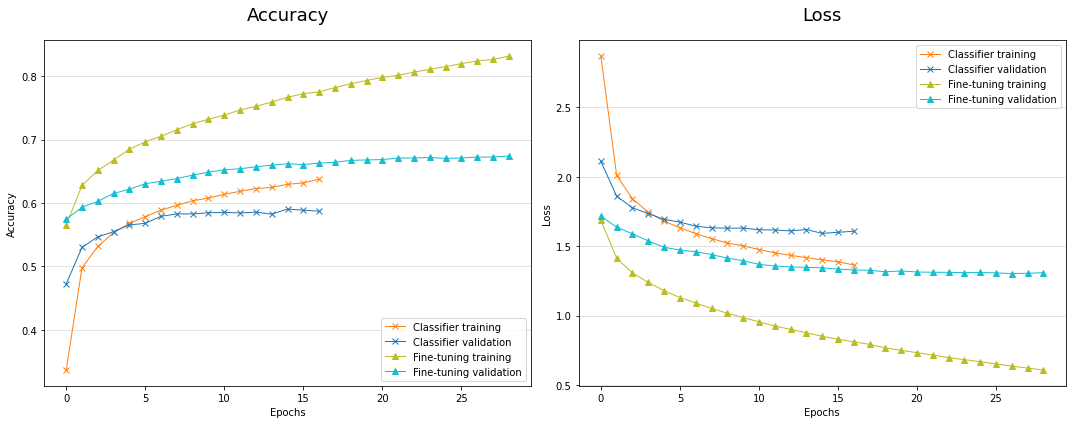

In [ ]:
# data from training with freezed mobilenet
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# data from fine-tuning training
ft_acc = ft_history.history['accuracy']
ft_val_acc = ft_history.history['val_accuracy']
ft_loss = ft_history.history['loss']
ft_val_loss = ft_history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))
epochs_1 = range(len(ft_acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:orange', marker='x', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.plot(epochs_1, ft_acc, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs_1, ft_val_acc, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, color='tab:orange', marker='x', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.plot(epochs_1, ft_loss, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs_1, ft_val_loss, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

# save graph
fig.savefig('train_plots.png')

Finally, we evaluate the model on the test set. The data augmentation layers are transparent during evaluation.

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/model/food_classifier.h5')
test_loss, test_accuracy = model.evaluate(test_set)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_accuracy)

60/60 [==============================] - 53s 717ms/step - loss: 1.2698 - accuracy: 0.6774
Test loss:  1.2698243856430054
Test accuracy:  0.6773597598075867
